In [503]:
# importing all necessary libraries and loading the table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, shapiro, ttest_1samp, ttest_ind, ttest_rel, chisquare, chi2, chi2_contingency, f_oneway, levene, kruskal
from statsmodels.graphics.gofplots import qqplot

cust_df = pd.read_csv('Customers.csv', encoding='unicode_escape')
prod_df = pd.read_csv('Products.csv')
sale_df = pd.read_csv('Sales.csv')

In [504]:
# Creating a variable to randomly pick the color palette for sns visualization
palette_choice = ["pastel", "rocket", "crest",
                  "viridis", "tab20", "tab20b", "tab20c", "hls"]
np.random.choice(palette_choice)

'crest'

### Performing Data Exploration and Cleaning for Customer Table

In [505]:
cust_df.head()

,CustomerKey,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Birthday
0,301,Female,Lilly Harding,WANDEARAH EAST,SA,South Australia,5523,Australia,Australia,7/3/1939
1,325,Female,Madison Hull,MOUNT BUDD,WA,Western Australia,6522,Australia,Australia,9/27/1979
2,554,Female,Claire Ferres,WINJALLOK,VIC,Victoria,3380,Australia,Australia,5/26/1947
3,786,Male,Jai Poltpalingada,MIDDLE RIVER,SA,South Australia,5223,Australia,Australia,9/17/1957
4,1042,Male,Aidan Pankhurst,TAWONGA SOUTH,VIC,Victoria,3698,Australia,Australia,11/19/1965


In [506]:
print(f"We have data for {cust_df.shape[0]} customers")

We have data for 15266 customers


In [507]:
# Checking for any null values in the Customers dataset
cust_df.isnull().sum()

CustomerKey     0
Gender          0
Name            0
City            0
State Code     10
State           0
Zip Code        0
Country         0
Continent       0
Birthday        0
dtype: int64

Since we will be dropping the state code column, we ignore the null values for state code

In [508]:
# Calculating the age for each customer to identify which age category does the customer fall in
from datetime import datetime
cust_df["Age"] = datetime.today().year - pd.to_datetime(cust_df["Birthday"]).dt.year
cust_df.Age.describe()

count    15266.000000
mean        55.774728
std         19.320142
min         22.000000
25%         39.000000
50%         56.000000
75%         72.000000
max         89.000000
Name: Age, dtype: float64

In [509]:
# Creating bins for Age range: 20-34, 35-44, 45-54, 55-64, 65+ (since the minimum Age value observed is 22 and maximum value observed is 89)
bins = [20, 35, 45, 55, 65, 90]
labels =  ["20-34", "35-44", "45-54", "55-64", "65+"]
cust_df["Age Category"] = pd.cut(cust_df["Age"], bins = bins, labels = labels)
cust_df["Age Category"].value_counts()


Age Category
65+      5413
20-34    3012
55-64    2334
35-44    2275
45-54    2232
Name: count, dtype: int64

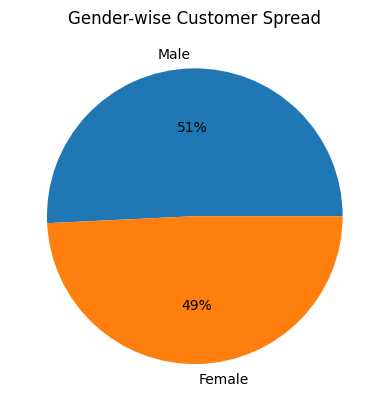

In [510]:
# Customer Spread By Gender
plt.title("Gender-wise Customer Spread")
plt.pie(cust_df["Gender"].value_counts(),
        labels=cust_df["Gender"].value_counts().index, autopct='%1.0f%%')
plt.show()

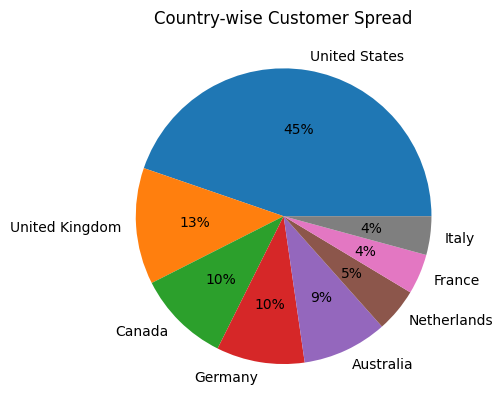

In [511]:
# Customer Spread across continents
plt.title("Country-wise Customer Spread")
plt.pie(cust_df["Country"].value_counts(),
        labels=cust_df["Country"].value_counts().index, autopct='%1.0f%%')
plt.show()

As per the above plot, we clearly see that USA and Canada alone make up 55% of the customer base.

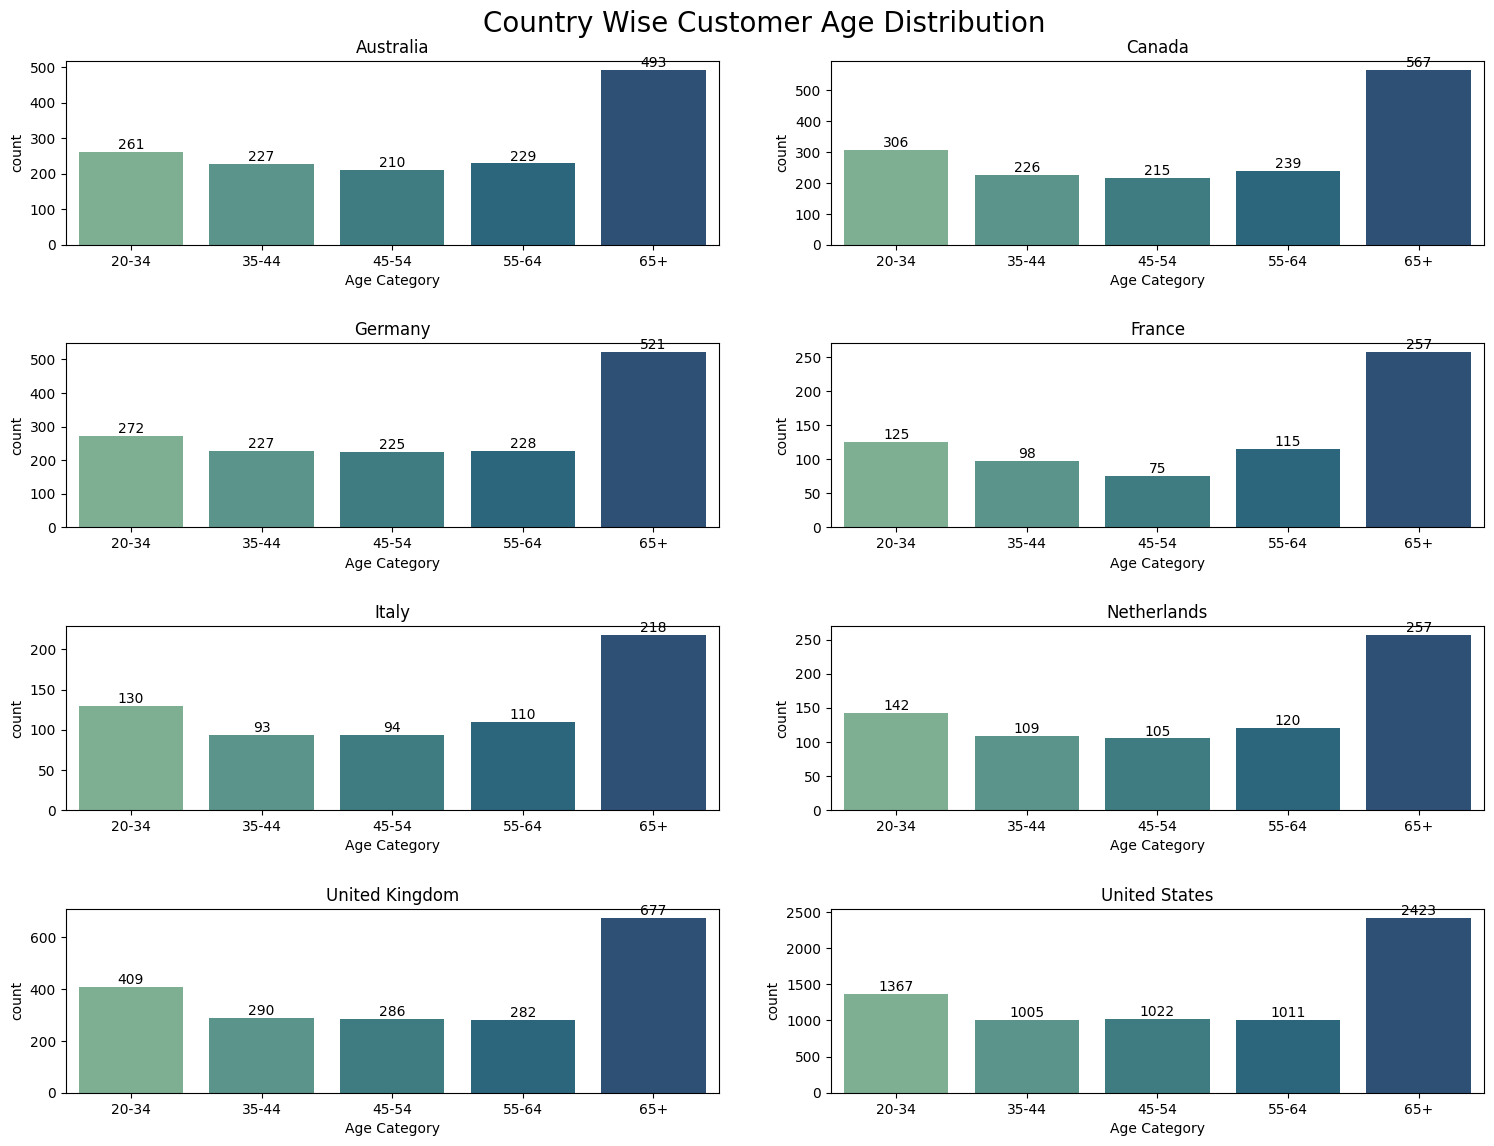

In [512]:
fig, ax = plt.subplots(4, 2, figsize=(16,12))
fig.tight_layout(pad=5.0)
fig.suptitle("Country Wise Customer Age Distribution", fontsize=20)
idx=0
for i in range(4):
    for j in range(2):
        ax[i,j].title.set_text(cust_df["Country"].unique()[idx])
        count_plot = sns.countplot(data=cust_df[cust_df["Country"] == cust_df["Country"].unique()[
                      idx]][["Continent", "Age Category"]], x="Age Category", hue="Age Category", ax=ax[i, j], palette="crest")
        for container in count_plot.containers:
            count_plot.bar_label(container)
        idx+=1

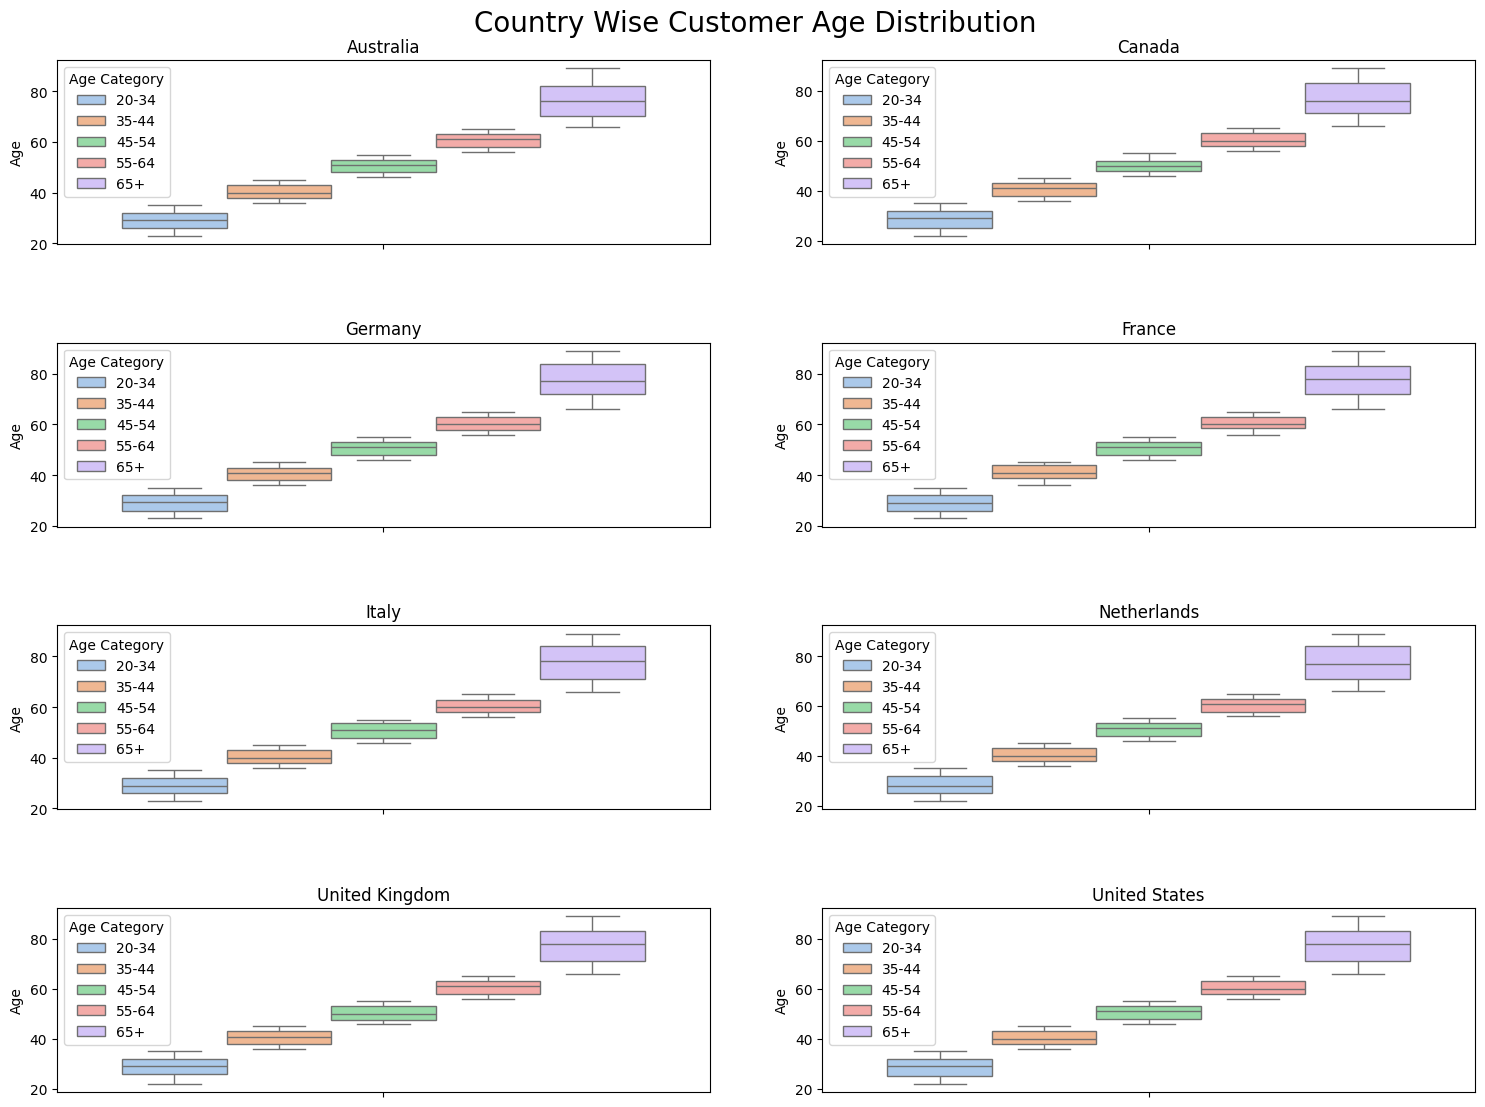

In [513]:
fig, ax = plt.subplots(4, 2, figsize=(16, 12))
fig.tight_layout(pad=5.0)
fig.suptitle("Country Wise Customer Age Distribution", fontsize=20)
idx = 0
for i in range(4):
    for j in range(2):
        ax[i, j].title.set_text(cust_df["Country"].unique()[idx])
        count_plot = sns.boxplot(data=cust_df[cust_df["Country"] == cust_df["Country"].unique()[
            idx]], y="Age", hue="Age Category", ax=ax[i, j], palette="pastel")
        idx += 1

Since we are performing analysis on revenue for ScalerMart, we will not be needing the below Column attributes in order to reduce the dimensionality of the dataset:
- `Name`
- `State Code`
- `Zip Code`
- `Birthday`
- `Continent`

Hence, we drop those columns for now.
> We retain the `CustomerKey` for creating a joined table to perform Revenue Analysis

In [514]:
cust_df.drop(['Name', 'State Code', 'Zip Code', 'Birthday', 'Continent'], axis=1, inplace=True)
cust_df.head()

,CustomerKey,Gender,City,State,Country,Age,Age Category
0,301,Female,WANDEARAH EAST,South Australia,Australia,85,65+
1,325,Female,MOUNT BUDD,Western Australia,Australia,45,35-44
2,554,Female,WINJALLOK,Victoria,Australia,77,65+
3,786,Male,MIDDLE RIVER,South Australia,Australia,67,65+
4,1042,Male,TAWONGA SOUTH,Victoria,Australia,59,55-64


### Performing Data Exploration and Cleaning for Products Table

In [515]:
prod_df.head()

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio
1,2,Contoso 512MB MP3 Player E51 Blue,Contoso,Blue,$6.62,$12.99,101,MP4&MP3,1,Audio
2,3,Contoso 1G MP3 Player E100 White,Contoso,White,$7.40,$14.52,101,MP4&MP3,1,Audio
3,4,Contoso 2G MP3 Player E200 Silver,Contoso,Silver,$11.00,$21.57,101,MP4&MP3,1,Audio
4,5,Contoso 2G MP3 Player E200 Red,Contoso,Red,$11.00,$21.57,101,MP4&MP3,1,Audio


In [516]:
# Checking for any null values in the Products dataset
prod_df.isnull().sum()

ProductKey        0
Product Name      0
Brand             0
Color             0
Unit Cost USD     0
Unit Price USD    0
SubcategoryKey    0
Subcategory       0
CategoryKey       0
Category          0
dtype: int64

In [517]:
print(f"We have data for {prod_df.shape[0]} products")

We have data for 2517 products


In [518]:
# Removing '$' from UnitCost and UnitPrice for easier computation and creating a new Attribute Profit for each Product
prod_df["Unit Price USD"] = prod_df["Unit Price USD"].str.strip("$").str.replace(',','')
prod_df["Unit Price USD"] = prod_df["Unit Price USD"].astype(float)
prod_df["Unit Cost USD"] = prod_df["Unit Cost USD"].str.strip("$").str.replace(',','')
prod_df["Unit Cost USD"] = prod_df["Unit Cost USD"].astype(float)
prod_df["Unit Profit USD"] = prod_df["Unit Price USD"] - prod_df["Unit Cost USD"]
prod_df["Unit Profit USD"].describe()

count    2517.000000
mean      209.174569
std       316.356201
min         0.470000
25%        36.730000
50%       108.000000
75%       231.720000
max      2139.770000
Name: Unit Profit USD, dtype: float64

In [519]:
# Creating bins for profit category attribute on the basis of min and max values for "unit profit USD"
bins = np.linspace(0, 2200, 6)
labels = [f"{int(i)} to {int(j)}" for i, j in zip(bins[:], bins[1:])]
prod_df["Profit Category"] = pd.cut(prod_df["Unit Profit USD"], bins=np.linspace(0, 2200, 6), labels=labels)
prod_df["Profit Category"].value_counts()

Profit Category
0 to 440        2223
440 to 880       178
880 to 1320       66
1760 to 2200      32
1320 to 1760      18
Name: count, dtype: int64

Since we are only concerned about the revenue, we will only focus on the profit category and profit values and we will drop attributes associated with the following:
- Unit Cost USD	
- Unit Price USD
- SubcategoryKey
- CategoryKey

In [520]:
prod_df.drop(["Unit Cost USD", "Unit Price USD", "SubcategoryKey", "CategoryKey"], axis=1, inplace=True)
prod_df.head()

,ProductKey,Product Name,Brand,Color,Subcategory,Category,Unit Profit USD,Profit Category
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,MP4&MP3,Audio,6.37,0 to 440
1,2,Contoso 512MB MP3 Player E51 Blue,Contoso,Blue,MP4&MP3,Audio,6.37,0 to 440
2,3,Contoso 1G MP3 Player E100 White,Contoso,White,MP4&MP3,Audio,7.12,0 to 440
3,4,Contoso 2G MP3 Player E200 Silver,Contoso,Silver,MP4&MP3,Audio,10.57,0 to 440
4,5,Contoso 2G MP3 Player E200 Red,Contoso,Red,MP4&MP3,Audio,10.57,0 to 440


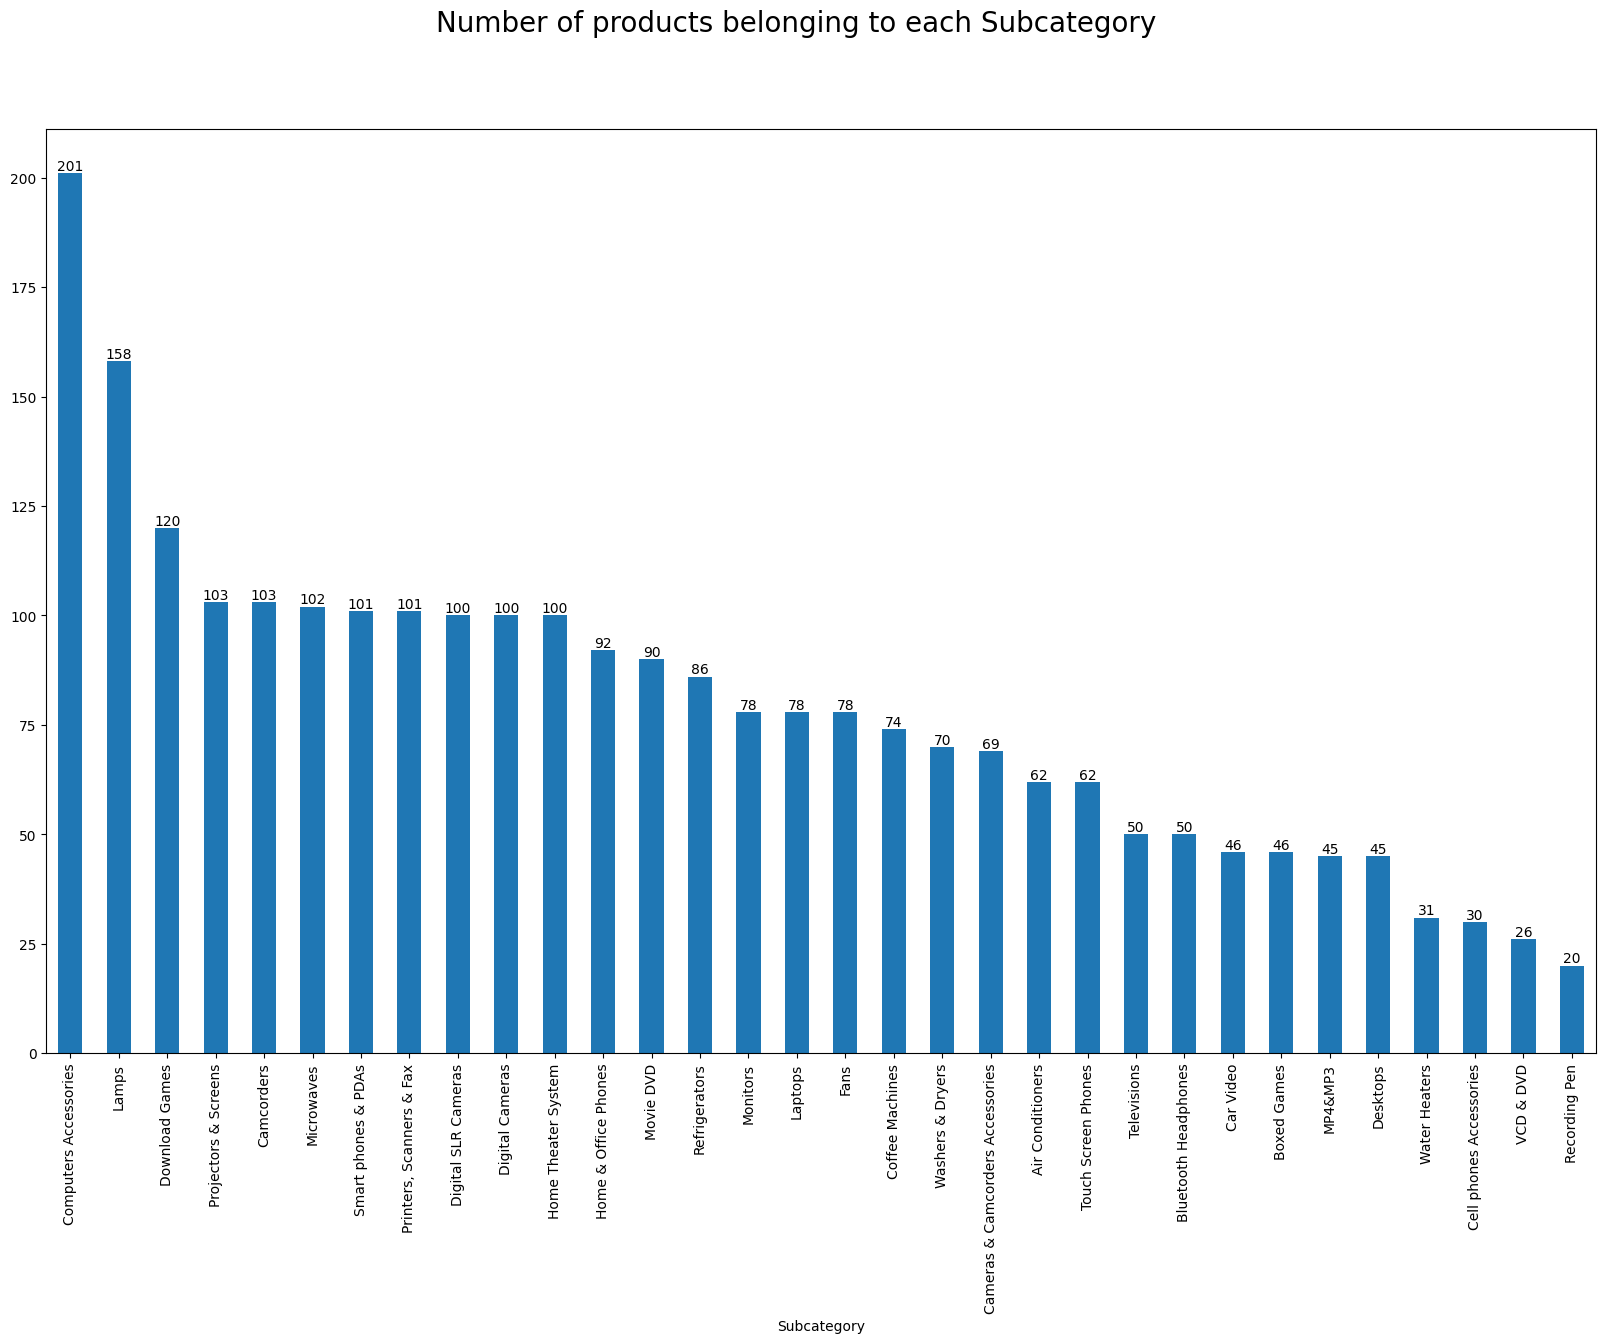

In [521]:
fig, _= plt.subplots(1, 1, figsize=(20,12))
fig.suptitle("Number of products belonging to each Subcategory", fontsize=20)
ax = prod_df.Subcategory.value_counts().plot(kind="bar")
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=90)
plt.show()

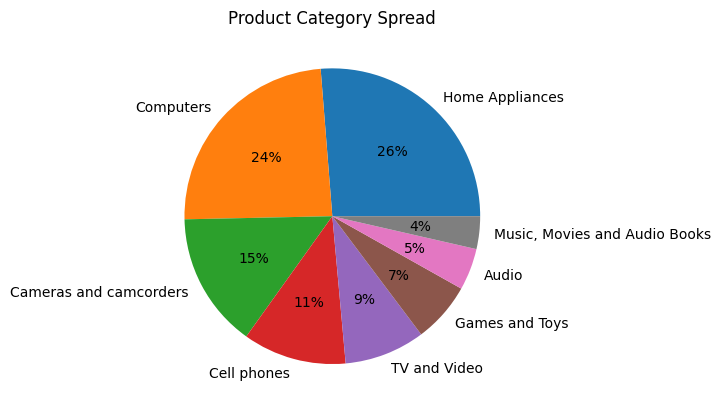

In [522]:
# Visualizing the Product Category Spread
plt.title("Product Category Spread")
plt.pie(prod_df["Category"].value_counts(),
        labels=prod_df["Category"].value_counts().index, autopct='%1.0f%%')
plt.show()

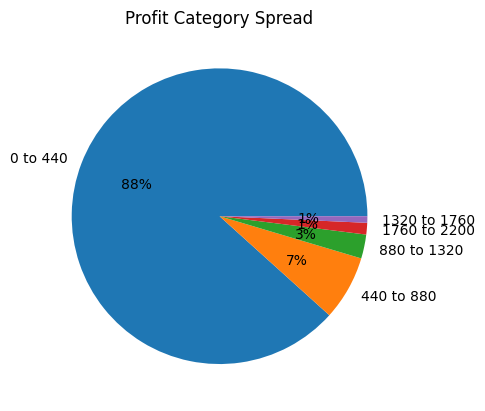

In [523]:
# Visualizing the Profit Category Spread
plt.title("Profit Category Spread")
plt.pie(prod_df["Profit Category"].value_counts(),
        labels=prod_df["Profit Category"].value_counts().index, autopct='%1.0f%%')
plt.show()

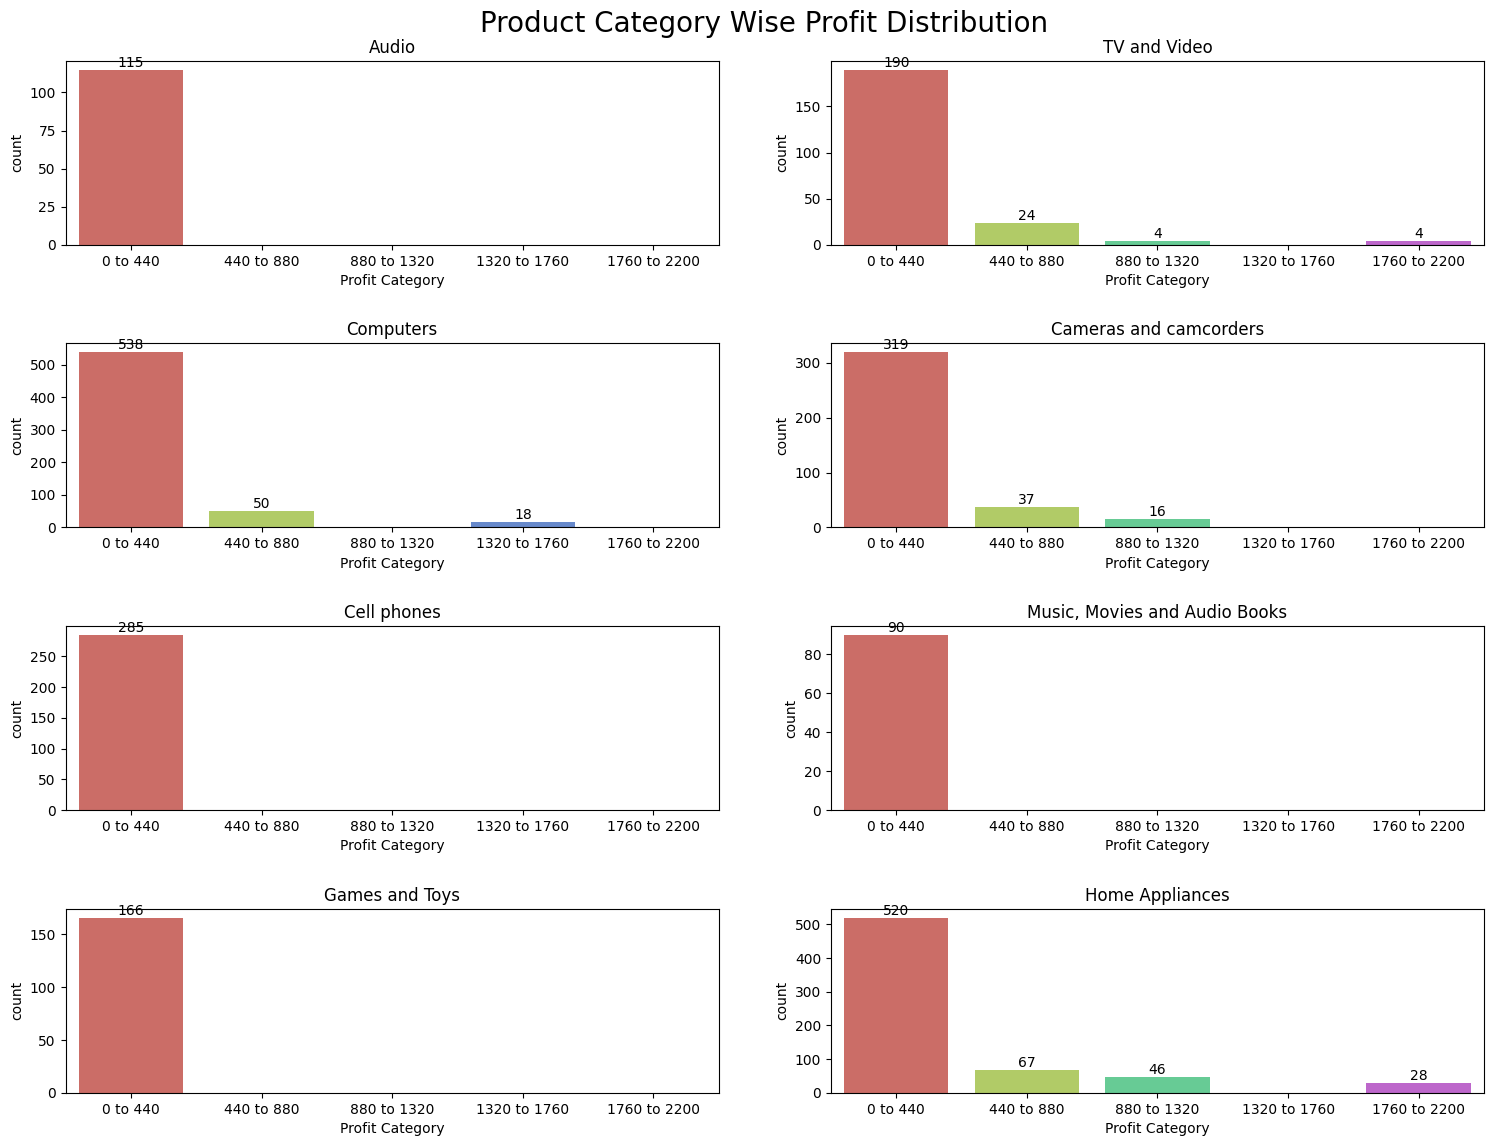

In [524]:
fig, ax = plt.subplots(4, 2, figsize=(16, 12))
fig.tight_layout(pad=5.0)
fig.suptitle("Product Category Wise Profit Distribution", fontsize=20)
idx = 0
for i in range(4):
    for j in range(2):
        ax[i, j].title.set_text(prod_df["Category"].unique()[idx])
        count_plot = sns.countplot(data=prod_df[prod_df["Category"] == prod_df["Category"].unique()[
            idx]][["Unit Profit USD", "Profit Category"]], x="Profit Category", hue="Profit Category", ax=ax[i, j], palette="hls", dodge=False)
        for container in count_plot.containers:
            count_plot.bar_label(container)
        idx += 1

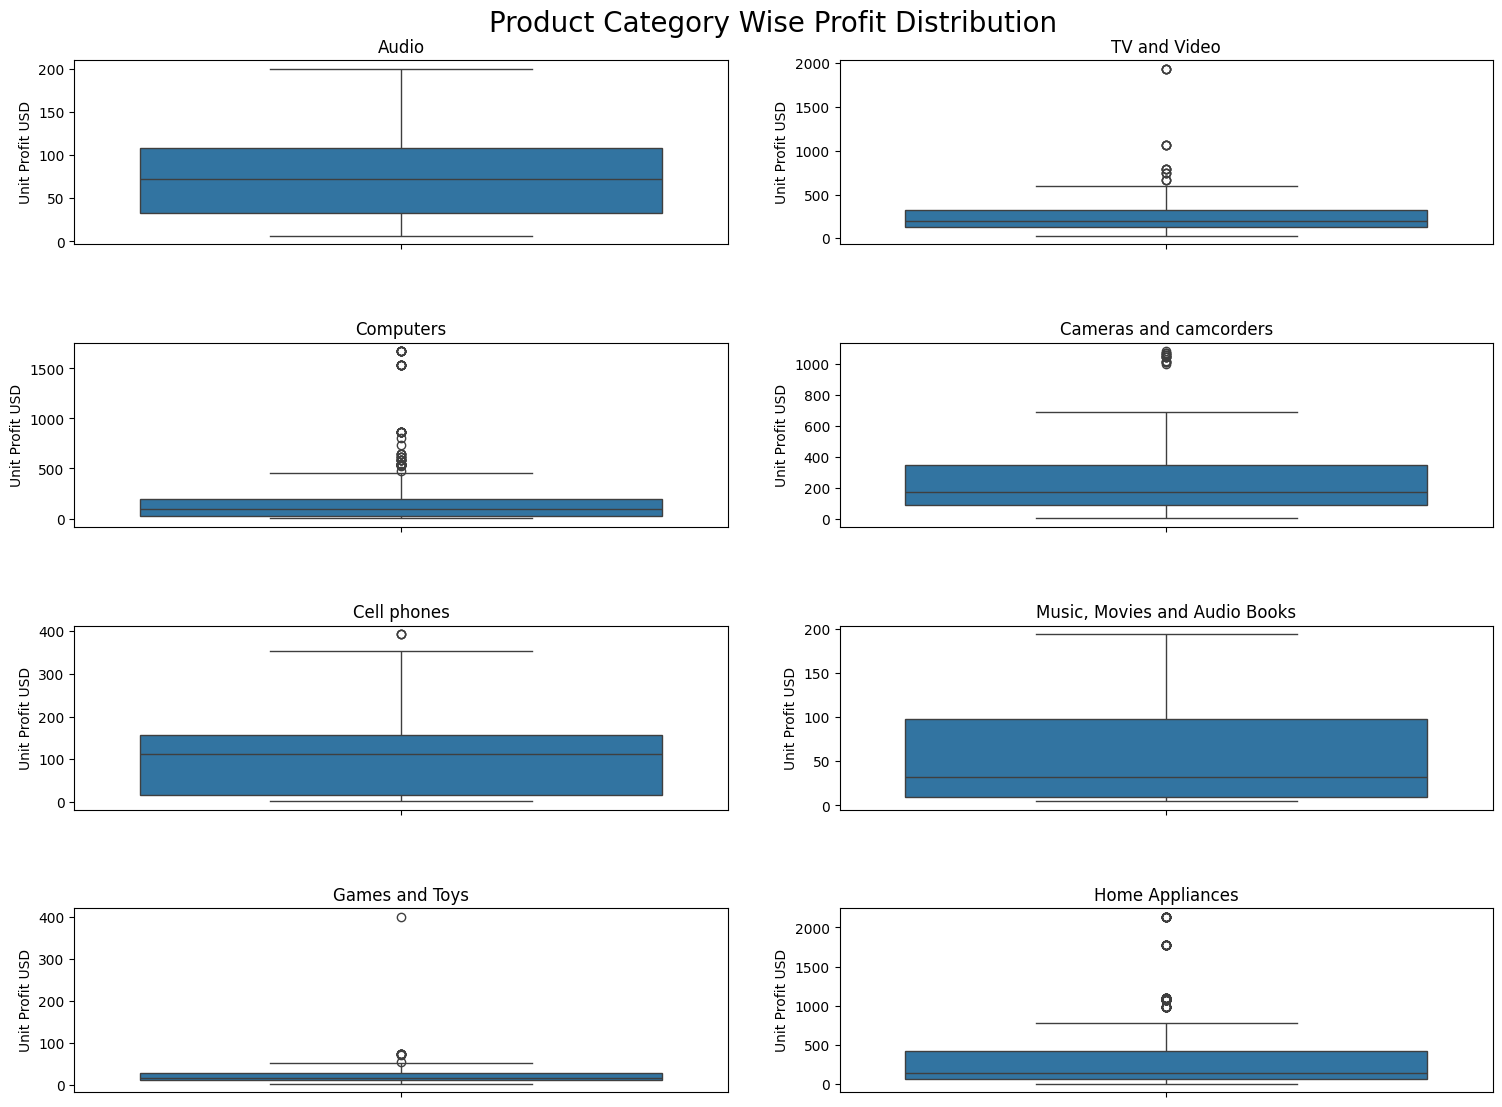

In [525]:
fig, ax = plt.subplots(4, 2, figsize=(16, 12))
fig.tight_layout(pad=5.0)
fig.suptitle("Product Category Wise Profit Distribution", fontsize=20)
idx = 0
for i in range(4):
    for j in range(2):
        ax[i, j].title.set_text(prod_df["Category"].unique()[idx])
        count_plot = sns.boxplot(data=prod_df[prod_df["Category"] == prod_df["Category"].unique()[
            idx]], y="Unit Profit USD", ax=ax[i, j])
        idx += 1

Here, it is apparent that the Computers, Cameras&Camcoders, Games&Toys and HomeAppliances have numerous outliers with varying median cost for each category

### Performing Data Exploration and Cleaning for Sales Table

In [526]:
sale_df.head()

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code
0,366000,1,1/1/2016,NaN,265598,10,1304,1,CAD
1,366001,1,1/1/2016,1/13/2016,1269051,0,1048,2,USD
2,366001,2,1/1/2016,1/13/2016,1269051,0,2007,1,USD
3,366002,1,1/1/2016,1/12/2016,266019,0,1106,7,CAD
4,366002,2,1/1/2016,1/12/2016,266019,0,373,1,CAD


In [527]:
# Changing the datatype for Order and Delivery Date for fetching the year
sale_df["Order Date"] = pd.to_datetime(sale_df["Order Date"])
sale_df["Delivery Date"] = pd.to_datetime(sale_df["Delivery Date"])
sale_df["Order Year"] = sale_df["Order Date"].dt.year
sale_df["Delivery Year"] = sale_df["Delivery Date"].dt.year

In [528]:
min_yr = sale_df["Order Year"].min()
max_yr = sale_df["Order Year"].max()
print(f"we have {sale_df.shape[0]} order records from year {min_yr} to {max_yr}")

we have 62884 order records from year 2016 to 2021


In [529]:
print("Total Orders Delivered:\n",
      sale_df[~sale_df["Delivery Date"].isnull()]["Order Year"].value_counts())
print("Total Orders Not Delivered:\n", 
      sale_df[sale_df["Delivery Date"].isnull()]["Order Year"].value_counts())

Total Orders Delivered:
 Order Year
2019    4694
2018    2944
2020    2487
2017    1546
2016    1161
2021     333
Name: count, dtype: int64
Total Orders Not Delivered:
 Order Year
2019    16917
2018    11244
2020     8539
2017     6396
2016     5744
2021      879
Name: count, dtype: int64


Here the `Line Item`, `Currency Code` and `StoreKey` will not be necessary for performing analysis on revenue. Hence, we will eradicate those 3 columns and merge with the `Products` and `Customers` table to calculate the profit earned for each product purcahsed per order and capture demographics about the customer associated with the purchase

In [530]:
sale_df.drop(["Line Item", "Currency Code", "StoreKey"], axis=1, inplace=True)
res_df = sale_df.merge(prod_df, how="left", on="ProductKey").merge(
    cust_df, how="left", on="CustomerKey")

In [531]:
# Calculating the Profit earned for each order item
res_df["Order Number"] = res_df["Order Number"].astype(str)
res_df["CustomerKey"] = res_df["CustomerKey"].astype(str)
res_df["ProductKey"] = res_df["ProductKey"].astype(str)
res_df["Product Order Profit"] = res_df["Quantity"] * res_df["Unit Profit USD"]
res_df.head()

,Order Number,Order Date,Delivery Date,CustomerKey,ProductKey,Quantity,Order Year,Delivery Year,Product Name,Brand,...,Category,Unit Profit USD,Profit Category,Gender,City,State,Country,Age,Age Category,Product Order Profit
0,366000,2016-01-01,NaT,265598,1304,1,2016,NaN,Contoso Lens Adapter M450 White,Contoso,...,Cameras and camcorders,36.73,0 to 440,Male,London,Ontario,Canada,53,45-54,36.73
1,366001,2016-01-01,2016-01-13,1269051,1048,2,2016,2016.0,A. Datum SLR Camera X136 Silver,A. Datum,...,Cameras and camcorders,285.53,0 to 440,Male,Auberry,California,United States,29,20-34,571.06
2,366001,2016-01-01,2016-01-13,1269051,2007,1,2016,2016.0,Fabrikam Microwave 1.5CuFt X1100 Black,Fabrikam,...,Home Appliances,445.30,440 to 880,Male,Auberry,California,United States,29,20-34,445.30
3,366002,2016-01-01,2016-01-12,266019,1106,7,2016,2016.0,Contoso SLR Camera M146 Orange,Contoso,...,Cameras and camcorders,173.92,0 to 440,Female,Red Deer,Alberta,Canada,62,55-64,1217.44
4,366002,2016-01-01,2016-01-12,266019,373,1,2016,2016.0,Adventure Works Laptop8.9 E0890 White,Adventure Works,...,Computers,159.80,0 to 440,Female,Red Deer,Alberta,Canada,62,55-64,159.80


In [532]:
# Calculating the total profit for each order
order_sum_df = res_df[["Order Number", "Product Order Profit"]
       ].groupby("Order Number").sum().reset_index()
order_sum_df.rename(columns={"Product Order Profit": "Total Profit Earned By Order"}, inplace=True)
order_sum_df.head()

,Order Number,Total Profit Earned By Order
0,1000000,9090.27
1,1000001,1497.02
2,1000002,2844.48
3,1000003,147.00
4,1000004,390.14


In [533]:
# Calculating the total profit by each Customer
cust_sum_df = res_df[["CustomerKey", "Product Order Profit"]
                      ].groupby("CustomerKey").sum().reset_index()
cust_sum_df.rename(
    columns={"Product Order Profit": "Total Profit Earned By Customer"}, inplace=True)
cust_sum_df

,CustomerKey,Total Profit Earned By Customer
0,1000050,730.51
1,1000168,5718.14
2,1000242,5082.81
3,100040,2169.75
4,1000489,1974.51
...,...,...
11882,999485,170.91
11883,999589,1671.04
11884,999701,621.52
11885,999709,103.60


In [534]:
# Adding the 2 calculated columns over to the resultant dataframe for revenue analysis
res_df = res_df.merge(order_sum_df, how="left", on="Order Number").merge(
    cust_sum_df, how="left", on="CustomerKey")
res_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62884 entries, 0 to 62883
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Order Number                     62884 non-null  object        
 1   Order Date                       62884 non-null  datetime64[ns]
 2   Delivery Date                    13165 non-null  datetime64[ns]
 3   CustomerKey                      62884 non-null  object        
 4   ProductKey                       62884 non-null  object        
 5   Quantity                         62884 non-null  int64         
 6   Order Year                       62884 non-null  int32         
 7   Delivery Year                    13165 non-null  float64       
 8   Product Name                     62884 non-null  object        
 9   Brand                            62884 non-null  object        
 10  Color                            62884 non-null  object   

In [535]:
# Calculating the frequency of purchases made by Each Customer per year
purchase_freq_df = res_df[["Order Number", "CustomerKey", "Order Year", "Country", "Total Profit Earned By Customer", "Total Profit Earned By Order"]].drop_duplicates(["Order Number"], keep="first")
purchase_freq_df.head()

,Order Number,CustomerKey,Order Year,Country,Total Profit Earned By Customer,Total Profit Earned By Order
0,366000,265598,2016,Canada,768.82,36.73
1,366001,1269051,2016,United States,1016.36,1016.36
3,366002,266019,2016,Canada,4929.63,3105.12
6,366004,1107461,2016,United Kingdom,6900.73,6663.48
8,366005,844003,2016,Netherlands,1013.28,1013.28


In [536]:
# Computing the frequency and monetary revenue generated by each Customer
annual_orders_df = purchase_freq_df[["Order Number", "CustomerKey", "Total Profit Earned By Order"]].groupby(
    ["CustomerKey"]).agg({"Order Number": "count", "Total Profit Earned By Order": "sum"}).reset_index()
annual_orders_df.rename(columns={"Order Number": "Total Orders", "Total Profit Earned By Order": "Total Revenue Generated"}, inplace=True)
annual_orders_df.head()

,CustomerKey,Total Orders,Total Revenue Generated
0,1000050,2,730.51
1,1000168,3,5718.14
2,1000242,2,5082.81
3,100040,1,2169.75
4,1000489,2,1974.51


In [537]:
# Calculating the customer orders with the highest frequency of Orders placed
print("Customer who has placed the higest number of orders")
annual_orders_df[annual_orders_df["Total Orders"]
                 == annual_orders_df["Total Orders"].max()]

Customer who has placed the higest number of orders


,CustomerKey,Total Orders,Total Revenue Generated
10320,723572,14,23440.78


In [538]:
# Calculating the customer responsible for highest revenue
print("Customer responsible for higest revenue")
annual_orders_df[annual_orders_df["Total Revenue Generated"] == annual_orders_df["Total Revenue Generated"].max()]

Customer responsible for higest revenue


,CustomerKey,Total Orders,Total Revenue Generated
4578,1702221,9,39606.02


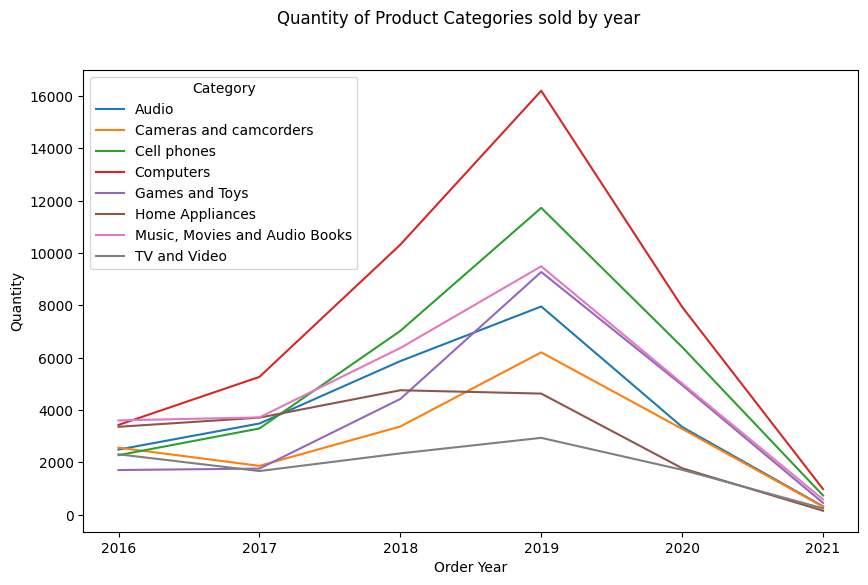

In [539]:
# Calculating the Quantity of Product Categories sold by year
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle("Quantity of Product Categories sold by year")
yearly_prod_cat_profit_df = res_df[["Category", "Order Year", "Quantity"]].groupby(
    ["Category", "Order Year"]).sum().reset_index()
ax = sns.lineplot(yearly_prod_cat_profit_df, x="Order Year",
                  y="Quantity", hue="Category")

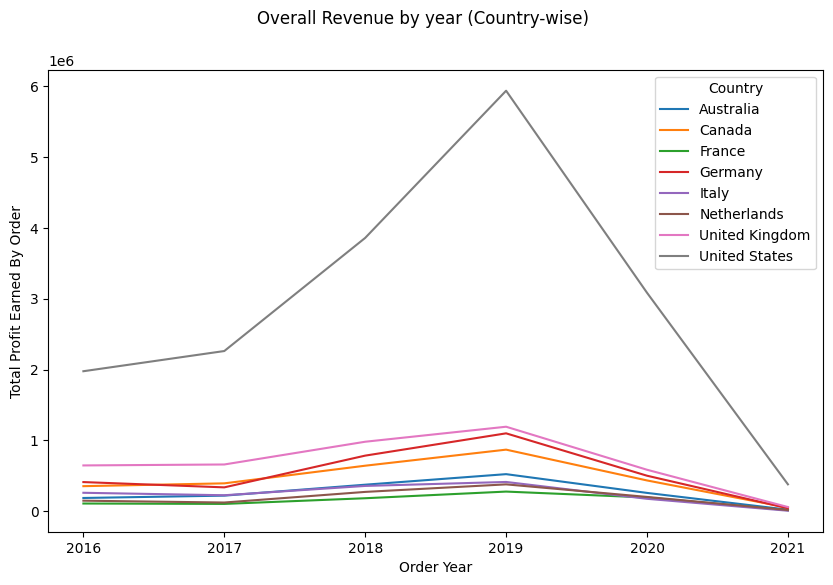

In [540]:
# Calculating the Overall Revenue by year
fig, ax = plt.subplots(1, 1, figsize=(10,6))
fig.suptitle("Overall Revenue by year (Country-wise)")
yearly_profit_df = purchase_freq_df[["Country", "Order Year", "Total Profit Earned By Order"]].groupby(["Country", "Order Year"]).sum().reset_index()
ax = sns.lineplot(yearly_profit_df, x="Order Year", y="Total Profit Earned By Order", hue="Country")

Potential Reasons for the Decline in Sales in 2020 could be because of the 3 primary reasons:

* **Impact of COVID-19 Pandemic**: 
The pandemic likely disrupted supply chains and reduced consumer spending due to economic uncertainty and lockdowns.
* **Changes in Customer Behavior**:
Shifts in purchasing behavior, such as reduced demand for non-essential goods, could have impacted sales as ScalerMart only provides Electronics for sale.
* **Competitive Market**:
Increased competition from other brands or online retailers offering similar products at competitive prices.


Based on the above analysis and since the customer may have moved to online only platform for making any purchases (due to the pandemic), we can recommend the below items:

* **Enhanced Online Presence:**
Improve Website Experience: Optimize the online shopping experience with a user-friendly interface, faster load times, and secure payment options.

* **Targeted Marketing Campaigns:**
Customer Segmentation: Use customer data to create targeted marketing campaigns based on demographics, purchase history, and preferences.

* **Email Marketing:** 
Develop personalized email marketing campaigns to re-engage past customers and promote new products.
Product Diversification:

* **New Product Launches:** 
Introduce new products or variants that align with current consumer trends and needs.

* **Bundle Offers:** 
Create attractive product bundles or discounts to increase the average order value.

* **Seasonal Sales:** 
Plan seasonal sales and promotions to attract customers during peak shopping periods.

* **Loyalty Programs:** Implement loyalty programs to reward repeat customers and encourage frequent purchases.
Adaptation to Market Changes:

* **Collect Feedback:**
Regularly collect customer feedback to identify areas for improvement and enhance the overall shopping experience.

* **Customer Support:** 
Provide excellent customer support to address queries and resolve issues promptly.
